In [80]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import numpy as np
from scipy.ndimage import distance_transform_edt
import random as ra

In [81]:
input_size = 784        #Number of input neurons (image pixels, 28x28)
intervention_size = 11
hidden_size0 = 1       #Number of classes (1) 
epochs = 10            #How many times we pass our entire dataset into our network 
batch_size = 64        #Input size of the data during one iteration 
learning_rate = 0.001   #How fast we are learning

In [82]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [83]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [84]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size, masks, threshold):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, intervention_size)
        self.fc1 = nn.Linear(intervention_size, hidden_size0)
        #self.fc2 = nn.Linear(hidden_size0, hidden_size1)
        #self.fc3 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.init_weights()
        
        self.register_buffer('fc0_mask', masks.bool())
        self.threshold = threshold

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        #nn.init.kaiming_normal_(self.fc2.weight)
        #nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):
        out = self.tanh(self.fc0(x))
        out = self.fc1(out)
       
        return out

    def apply_fc0_constraints(self):
        with torch.no_grad():
            w = self.fc0.weight.data
            mask = self.fc0_mask

            w[~mask] = 0

            #threshold
            #w[mask & (w.abs() < self.threshold)] = (
            #    self.threshold * w[mask & (w.abs() < self.threshold)].sign() #the fucking sign become 0 for 0 from init!!!
            #)

            idx = mask & (w.abs() < self.threshold)
            w_sign = torch.sign(w[idx])
            w_sign[w_sign == 0] = 1 #now it won't be 0!
            w[idx] = self.threshold * w_sign




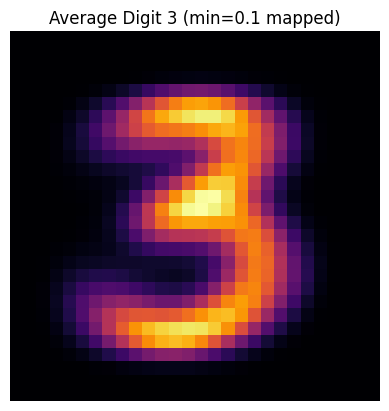

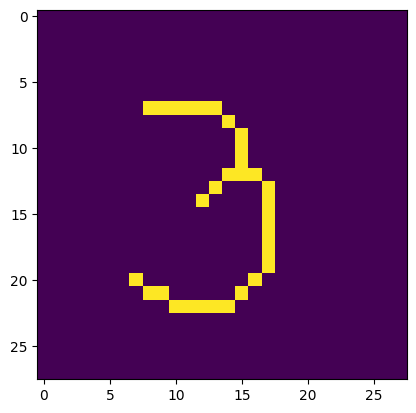

In [85]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False)

target_digit = 3

sum_img = torch.zeros((28, 28))
count = 0

for imgs, labels in trainloader:
    mask = labels == target_digit
    if mask.any():
        selected_imgs = imgs[mask]  # shape: [N, 1, 28, 28]
        sum_img += selected_imgs.sum(dim=0).squeeze(0)
        count += mask.sum().item()

avg_img = sum_img / count

plt.imshow(avg_img, cmap='inferno')
plt.axis('off')
plt.title(f'Average Digit {target_digit} (min=0.1 mapped)')
plt.show()

#print(avg_img)

to_skel = (avg_img > 0.1).float()

skel = skeletonize(to_skel.cpu().numpy())
plt.imshow(skel)

#print(to_skel)

In [86]:
def extract_concepts(skeleton, img):
    img_np = img.cpu().numpy()
    skeleton_np = skeleton.astype(bool)

    size = 10
    maxoverlap = 7
    height, width = 28, 28

    neighbors_offsets = [(dy, dx) for dy in [-1,0,1] for dx in [-1,0,1] if not (dy == 0 and dx == 0)]

    def get_neighbors(p):
        y, x = p
        result = []
        for dy, dx in neighbors_offsets:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and skeleton_np[ny, nx]:
                result.append((ny, nx))
        return result

    groups = []
    groups_sets = []

    def dfs(path, visited):
        if len(path) == size:
            path_set = set(path)
            if not any(len(path_set & g) > maxoverlap for g in groups_sets):
                groups.append(np.array(path))
                groups_sets.append(path_set)
            return

        candidates = set()
        for p in path:
            for n in get_neighbors(p):
                if n not in visited:
                    candidates.add(n)

        for n in candidates:
            visited.add(n)
            dfs(path + [n], visited)
            visited.remove(n)

    all_pixels = list(zip(*np.nonzero(skeleton_np)))

    for start in all_pixels:
        dfs([start], set([start]))

    tensor_groups = torch.stack([
        torch.zeros((height, width), dtype=torch.uint8).index_put_(
            (torch.tensor(g[:, 0]), torch.tensor(g[:, 1])), 
            torch.ones(len(g), dtype=torch.uint8)
        ) for g in groups
    ])

    original_clusters = torch.zeros_like(tensor_groups)
    original_clusters = []

    for i in range(tensor_groups.shape[0]):
        mask = tensor_groups[i].numpy()
        inverted_mask = 1 - mask
        distance = distance_transform_edt(inverted_mask)
        within_range_mask = (distance <= 3.5).astype(np.float32)
        new_input = torch.from_numpy(img_np * within_range_mask).float()
        original_clusters.append(new_input)

    return tensor_groups, original_clusters

In [87]:
tensors, originals = extract_concepts(skeleton=skel, img=avg_img)

In [88]:
ind = 0

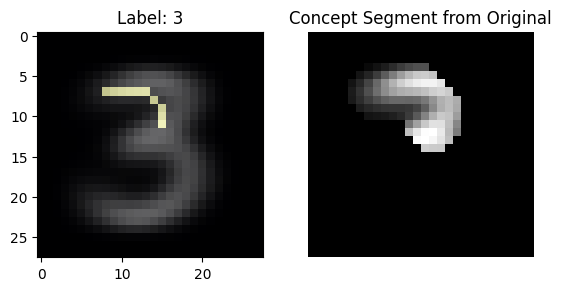

11


In [89]:
plt.subplot(1, 2, 1)
plt.imshow(avg_img.view(28, 28), cmap="gray") #or squeeze()
plt.imshow(tensors[ind].cpu().numpy(), cmap='inferno', alpha=0.6)
plt.title(f"Label: {target_digit}")

plt.subplot(1, 2, 2)
plt.title('Concept Segment from Original')
plt.imshow(originals[ind], cmap='gray')

plt.axis('off')
plt.show()
print(len(tensors))

ind = ind + 1 if ind < len(tensors) - 1 else 0

In [90]:
#input: 784 grayscale
#hidden layer 0: 11 neurons
#hidden layer 1: 32 neurons

#masks from 784 to 11:
all_masks = []

for cluster in originals:
    binary_mask = (cluster.view(-1) != 0) #size (784,)
    all_masks.append(binary_mask)

len(all_masks) #11 clusters -> each cluster defines rules for each of the 11 hidden neurons

mask_tensor = torch.stack(all_masks).to(torch.bool)


#constraints for FFN for each cluster-neuron pair:
#weights to neuron that aren't in the binary positive (1) cluster must be 0
#weights from the 1's (the corresponding cluster) must retain a weight >= 0.5, or <= -0.5
#(tanh is used, or should I use ReLU and only allow >= 0.5?, idk which one would make it easier for the net to adapt to the constraints...)

In [91]:
bin_digit = 3

In [92]:
CUDA = torch.cuda.is_available()
net = Net(input_size, hidden_size0, 0, 0, masks=mask_tensor, threshold=1)
if CUDA:
    net = net.cuda()

criterion = nn.BCEWithLogitsLoss() #uses sigmoid
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) #sorry, using "z" over "s" makes code more readable to most people
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)


#Training
for epoch in range(epochs):
    total_train_samples = 0
    correct_train = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):   
        #(batch,1,28,28)
        images = images.view(-1, 28*28)   
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()

        #modifying the dataset for binary prediction, unlike mnist:
        bin_mask = (labels == bin_digit)
        other_mask = ~bin_mask

        bin_images = images[bin_mask]
        bin_labels = labels[bin_mask]

        other_images = images[other_mask]
        other_labels = labels[other_mask]

        n_bin = bin_images.size(0)

        if n_bin == 0:
            continue

        target_other_per_digit = n_bin

        balanced_other_images = []
        balanced_other_labels = []

        for digit in range(10):
            if digit == bin_digit:
                continue
            digit_mask = (other_labels == digit)
            digit_images = other_images[digit_mask]
            digit_labels = other_labels[digit_mask]

            if digit_images.size(0) < target_other_per_digit and digit_images.size(0) > 0:
                indices = torch.randint(0, digit_images.size(0), (target_other_per_digit,), device=digit_images.device)
            else:
                indices = torch.randperm(digit_images.size(0), device=digit_images.device)[:target_other_per_digit]

            balanced_other_images.append(digit_images[indices])
            balanced_other_labels.append(digit_labels[indices])

        if len(balanced_other_images) == 0:
            continue

        balanced_other_images = torch.cat(balanced_other_images, dim=0)
        balanced_other_labels = torch.cat(balanced_other_labels, dim=0)

        batch_images = torch.cat([bin_images, balanced_other_images], dim=0)
        batch_labels = torch.cat([bin_labels, balanced_other_labels], dim=0)

        perm = torch.randperm(batch_images.size(0), device=batch_images.device)
        batch_images = batch_images[perm]
        batch_labels = batch_labels[perm]

        batch_labels_bin = (batch_labels == bin_digit).float().view(-1, 1)



        ######
        outputs = net(batch_images)       
        predicted = (torch.sigmoid(outputs) >= 0.5).float()                                            
        total_train_samples += batch_labels_bin.size(0)  #total examples used in training
        correct_train += (predicted == batch_labels_bin).sum().item()
        loss = criterion(outputs, batch_labels_bin)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()                                   
        optimizer.step()                             
        net.apply_fc0_constraints()

    accuracy = 100 * correct_train / total_train_samples
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader):.3f}, Training Accuracy: {accuracy:.3f}%')
    
print("DONE TRAINING!")

torch.save(net.state_dict(), f'conceptual_bin_model_0.pth') #'binary_ffn_all.pth')


Epoch [1/10], Training Loss: 0.398, Training Accuracy: 83.372%
Epoch [2/10], Training Loss: 0.230, Training Accuracy: 91.132%
Epoch [3/10], Training Loss: 0.188, Training Accuracy: 93.080%
Epoch [4/10], Training Loss: 0.171, Training Accuracy: 93.990%
Epoch [5/10], Training Loss: 0.160, Training Accuracy: 94.305%
Epoch [6/10], Training Loss: 0.155, Training Accuracy: 94.634%
Epoch [7/10], Training Loss: 0.150, Training Accuracy: 94.816%
Epoch [8/10], Training Loss: 0.146, Training Accuracy: 94.865%
Epoch [9/10], Training Loss: 0.142, Training Accuracy: 95.028%
Epoch [10/10], Training Loss: 0.140, Training Accuracy: 95.054%
DONE TRAINING!


In [ ]:
from torch.utils.data import DataLoader, Subset
import torch

bin_digit = 3
num_samples = 500

idx_3 = [i for i, (_, label) in enumerate(test_dataset) if label == bin_digit]
idx_not_3 = [i for i, (_, label) in enumerate(test_dataset) if label != bin_digit]

idx_3 = idx_3[:num_samples // 2]
idx_not_3 = idx_not_3[:num_samples // 2]

balanced_indices = idx_3 + idx_not_3
balanced_subset = Subset(test_dataset, balanced_indices)
balanced_loader = DataLoader(balanced_subset, batch_size=64, shuffle=False)

net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in balanced_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        labels_bin = (labels == bin_digit).float().view(-1, 1)

        outputs = net(images)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()

        correct += (predicted == labels_bin).sum().item()
        total += labels_bin.size(0)

print(f'Balanced Accuracy on 50% "{bin_digit}" vs 50% not-{bin_digit}: {100 * correct / total:.2f}%')


Balanced Accuracy on 50% "3" vs 50% not-3: 80.80%


Prediction: 1.0


/tmp/ipykernel_163699/3399425639.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


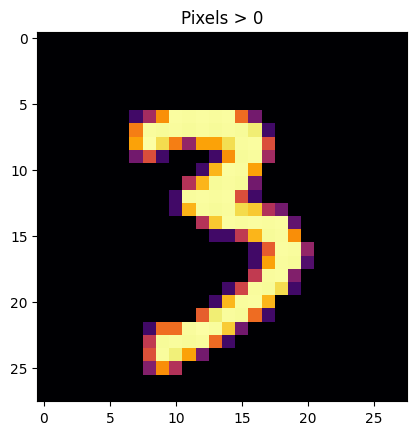

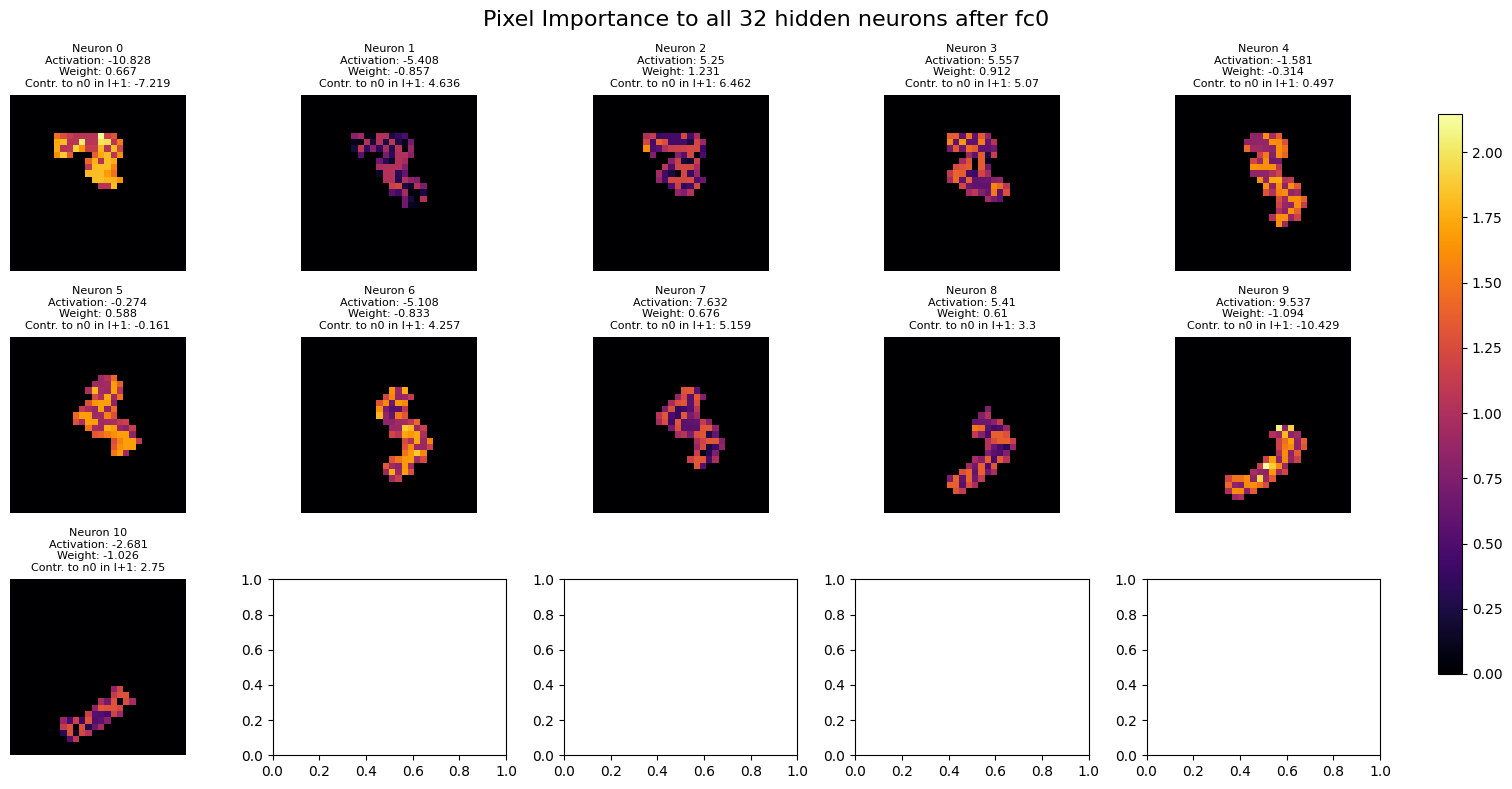

In [94]:

inputs, labels = next(iter(test_loader))
dig_to_check = 3

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break
    
#plt.imshow(img, cmap="inferno")

img_flat = img.view(-1)

weights = net.fc0.weight.detach().cpu()
biases = net.fc0.bias.detach().cpu()
contribs = weights * img_flat #32, 784

max_val = contribs.max()
contribs_norm = contribs / max_val
contribs_imgs = contribs_norm.view(-1, 28, 28)

mask = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    1
)

contribs_imgs += biases[:, None, None]
contribs_imgs *= mask #no bias where background = 0

contribs_imgs = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    torch.where(
        contribs_imgs.abs() > 0.0,
        contribs_imgs,
        torch.tensor(0.0, device=contribs_imgs.device)
    )
)

activation_modified = []
for i, mat in enumerate(contribs_imgs):
    mat = mat.sum().item()
    #print(f"{i}: {mat}")
    activation_modified.append(mat)


combo = contribs_imgs.max(dim=0).values

activations = net.fc0(img.view(1, -1).cuda()).squeeze()

next_neuron_idx = 0

weights_to_neuron = net.fc1.weight[next_neuron_idx]
contribution = activations * weights_to_neuron

#print(weights_to_neuron.size())

img_edit = torch.where(
    img != 0,
    torch.where(
        img > 0.2,
        img,
        0.2
    ),
    0.0
)

plt.imshow(img_edit, cmap="inferno")
plt.title("Pixels > 0")

output = net(img.view(-1).cuda())
pred = (torch.sigmoid(output) >= 0.5).float()
print(f"Prediction: {pred.item()}")

fig, axes = plt.subplots(3, 5, figsize=(16, 8))

vmax = contribs_imgs.max().item()

for i, ax in enumerate(axes.flat):
    if i >= 11:
        continue
    im = ax.imshow(contribs_imgs[i].abs(), cmap='inferno', vmin=0, vmax=vmax)
    ax.set_title(f'Neuron {i}\nActivation: {round(activations[i].item(), 3)}\nWeight: {round(weights_to_neuron[i].item(), 3)}\nContr. to n{next_neuron_idx} in l+1: {round(contribution[i].item(), 3)}', fontsize=8)
    ax.axis('off')

fig.suptitle('Pixel Importance to all 32 hidden neurons after fc0', fontsize=16)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


